<div style="text-align: center"> Gold Price Forecasting</div>

<div style="text-align: center">Done by Group 2 </div>

| No | Name         | Student id  |
|:--:|:-------------|:-----------:|
| 1. | Chia Xiu Xiang | AIT2204140 |
| 2. | Heng Kee Liang | AIT2109941 |

<a id = "Table_of_content"></a>
# Table of content
### 1. [Introduction](#Introduction)
### 2. [Data Preparation](#Data_Preparation)
#### &emsp;► [Data Preprocessing](#Data_Preparation1)
#### &emsp;► [NaN Values Checking](#Data_Preparation2)
#### &emsp;► [Augmented Dicky-Fuller test](#Data_Preparation3)
#### &emsp;► [Differencing](#Data_Preparation4)
#### &emsp;► [ACF,PACF Finding](#Data_Preparation5)
#### &emsp;► [Splitting Data](#Data_Preparation6)
### 3. [Model Building](#modelBuilding)
### 4. [ARIMA](#model)
#### &emsp;► [Evaluation(ARIMA)](#model1)
#### &emsp;► [Denormalisation](#model2)
#### &emsp;► [Forecasting](#model3)
### 4. [Expontential Smoothing Model](#ets)
#### &emsp;► [Seasonal Decomposition](#ets1)
#### &emsp;► [ETS Building](#ets2)
#### &emsp;► [Evaluation(ETS)](#ets3)
#### &emsp;► [Denormalisation](#ets4)
#### &emsp;► [Forecasting](#ets5)
### 4. [ARIMA with Seasonal and Exogenoues](#s)
### 5. [ARIMAX](#AX)
#### &emsp;► [Data Preprocessing](#AX1)
#### &emsp;► [Augmented Dicky-Fuller test](#AX2)
#### &emsp;► [Differencing](#AX3)
#### &emsp;► [ACF,PACF Finding](#AX4)
#### &emsp;► [Splitting Data](#AX5)
#### &emsp;► [ARIMAX Building](#AX6)
#### &emsp;► [Evaluation(ARIMAX)](#AX7)
#### &emsp;► [Denormalisation](#AX8)
#### &emsp;► [Forecasting](#AX9)
### 6. [SARIMAX](#SAX)
#### &emsp;► [SARIMAX Building](#SAX1)
#### &emsp;► [Evaluation(SARIMAX)](#SAX2)
#### &emsp;► [Denormalisation](#SAX3)
#### &emsp;► [Forecasting](#SAX4)
### 5. [Evaluation](#eva)
#### &emsp;► [Metrics](#eva1)
#### &emsp;► [Results Plotting](#eva2)
### 6 [Forecasting Results](#f)
#### &emsp;► [Results Plotting](#f1)
#### &emsp;► [Comparison (forecast vs actual)](#f2)
### 7. [Conclusion](#Conclusion)

# Introduction

In this notebook, we will implement some time series models to forecast the gold price in future 30 days.
We also will do comparison between some time series models on prediction and forecasting results

In [1]:
# Import general libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt
import statsmodels.api as sm
import scipy.stats as stats
import time

# Data Preparation

In [2]:
# Load dataset into dataframe
df = pd.read_csv("lat.csv")
df["Date"] = pd.to_datetime(df["Date"])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-08-30,273.899994,273.899994,273.899994,273.899994,273.899994,0.0
1,2000-08-31,274.799988,278.299988,274.799988,278.299988,278.299988,0.0
2,2000-09-01,277.000000,277.000000,277.000000,277.000000,277.000000,0.0
3,2000-09-02,276.699997,276.699997,276.699997,276.699997,276.699997,0.5
4,2000-09-03,276.399994,276.399994,276.399994,276.399994,276.399994,1.0


### Data Preprocessing

### NaN Values Checking

In [3]:
df.isnull().sum()
#There is empty null value in this data

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Data Normalisation

In [4]:
#Transform data using Box-Cox transformation to make the data more smoother
transformed_data, best_lambda = stats.boxcox(df["Close"])
print("Best Lambda: ",best_lambda)

#Standard scale the data to decrease the error
from sklearn.preprocessing import StandardScaler

# Extract column from DataFrame as array
close = transformed_data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(close.reshape(-1,1))
close = normalized_data.flatten()
df['Close_Normalised'] = close
#So the lambda value is 0.8086
#Later can use it to detransform the data for comparison to actual value

Best Lambda:  0.8086441732170241


### Augmented Dicky-Fuller test

In [5]:
def stat(da):
    # Perform the stationarity check using the augmented Dicky-Fuller test
    result = adfuller(da)
    print("ADF Statistic: ", result[0])
    print("P-value: ", result[1])
    print("Critical values: ")
    #Key represent the significance level and value represents the corresponding critical value
    for key, value in result[4].items():
        print(f"{key}: {value}")
    

In [6]:
stat(df['Close_Normalised'])
#ADF test to checking stationarity of data
#H0:data is non-stationary
#H1:data is stationary
#Condition to reject:p-value<0.05,ADF stat lower than Critical Values
#Results: 
#p-value = 0.915 >0.05 indicates that the null hypothesis is fail to reject
#ADF stat = -0.37,Smallest Critical Values: -3.43
#-0.37>-3.43,ADF stat is more negative indicates that the null hypothesis
#Conclusion:The data is non-stationary so need to apply differencing to make it stationary

ADF Statistic:  -0.36514934139495464
P-value:  0.9157569954158168
Critical values: 
1%: -3.4311041199290315
5%: -2.861873270539268
10%: -2.5669473949551955


### Differencing

In [7]:
# Manually difference the data
data_diff = df['Close_Normalised'].diff().dropna()
df["Close_diff"] = data_diff

#Check if data exist null value then use specific mean value to replace the Nan value
if df.isnull().values.any():
    #If nan values is detected then print "Got Missing Values"
    print("Got Missing Values")
    df.fillna(df.mean(),inplace = True)
#The missing values was printed thus Nan values exists
#The Nan value might be the first value of the data because the differencing will drop the first column

Got Missing Values


C:\Users\PC\AppData\Local\Temp\ipykernel_17520\2956246048.py:9: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df.fillna(df.mean(),inplace = True)


In [8]:
stat(df["Close_diff"])
#After differencing check stationarity again.If still non-stationary continue differencing until the data is stationary\
#Results: 
#p-value = 0.0<0.05 which extremely low and indicates that the null hypothesis is rejected
#ADF stat = -24.81,Smallest Critical Values: -3.43
#--24.81<-3.43 indicates that the null hypothesis
#Conclusion:The data is stationary so this data is qualified to be time series data

ADF Statistic:  -24.810831034187974
P-value:  0.0
Critical values: 
1%: -3.431104032973037
5%: -2.861873232115414
10%: -2.566947374501906


### ACF ,PACF Finding

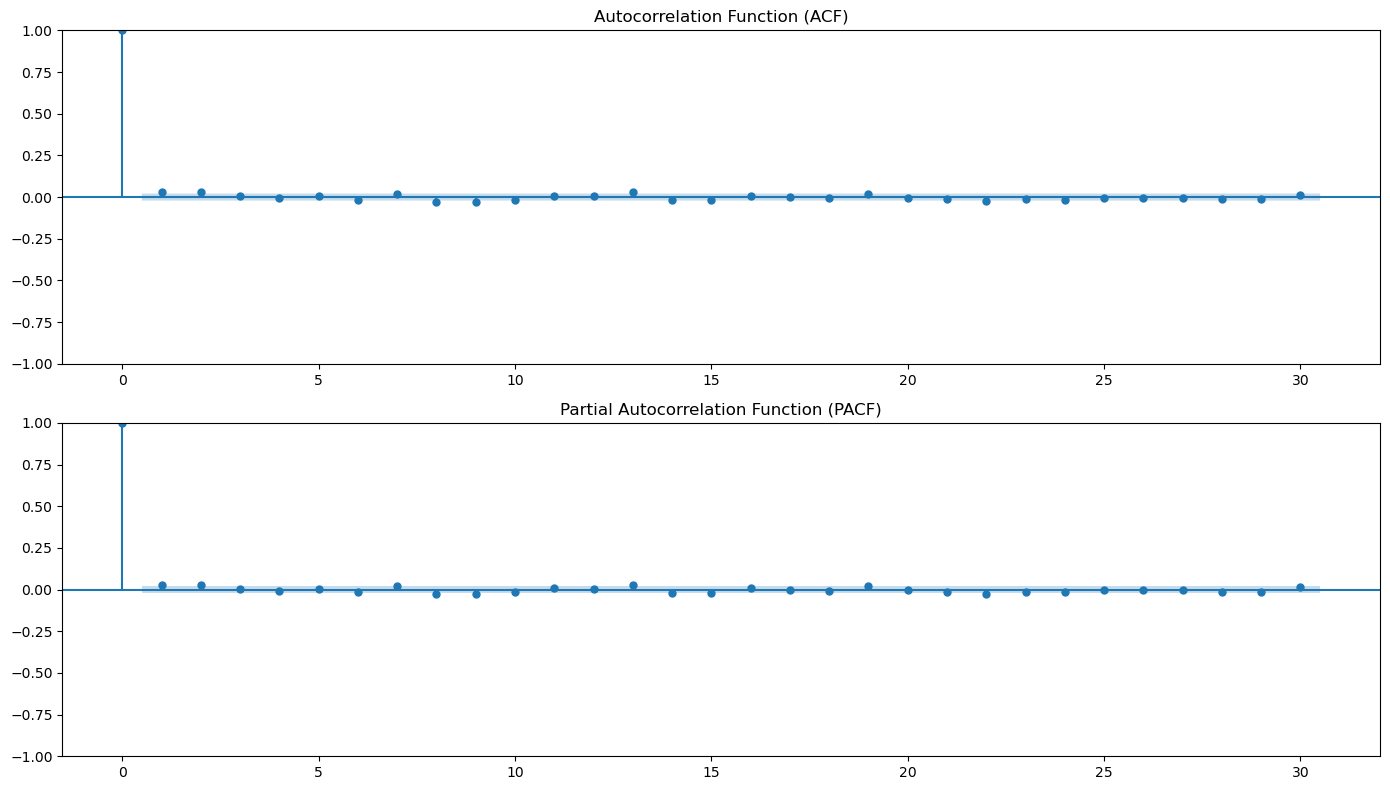

In [9]:
plt.figure(figsize=(14, 8))
# ACF plot
plt.subplot(2, 1, 1)
plot_acf(df["Close_diff"], lags=30, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
# PACF plot
plt.subplot(2, 1, 2)
plot_pacf(df["Close_diff"], lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()
#The ACF and PACF use range 30 of lag values to find the significant values
#After plotting the range of ACF and PACF is -0.25~ 1
#0 is the signifant value of ACF and PACF after observing to the graph. Besides that is the 1.
#There is hard to find the significant values of ACF and PACF so can perform some mathematics technique to solve the problem


In [10]:
#Due to hard to find the significant values from plotting thus compute the threshold of them and count the values

# Get ACF and PACF values
acf_values = acf(df["Close_diff"], nlags=30)
pacf_values = pacf(df["Close_diff"], nlags=30)

# Calculate the 95% confidence interval threshold
n = len(df["Close_diff"])
threshold = 1.96 / np.sqrt(n)
# Count significant values for p and q
significant_p_values = sum(abs(pacf_values[1:]) > threshold)
significant_q_values = sum(abs(acf_values[1:]) > threshold)

# Print the results
print(f"Number of significant p values: {significant_p_values}")
print(f"Number of significant q values: {significant_q_values}")
p = significant_p_values#set p = significant p values for later use
d = 1 #d = 1 because there is one differencing applied
q = significant_q_values#set q = significant q values for later use

#Result: the significant p and q values are 6.Thus later can direct use them to fit inside time series model to train

Number of significant p values: 6
Number of significant q values: 6


### Splitting Data

In [11]:
# Split the data into training and testing sets
#Train_data is 80% of whole data
#Test_size is 80% of whole data
train_size = int(len(df["Close_diff"]) * 0.8)
train_data = df["Close_diff"][:train_size]
test_data = df["Close_diff"][train_size:]

print("Length of Train Data: ",len(train_data))

Length of Train Data:  6952


# Model Building

# ARIMA

In [12]:
# Define the ARIMA model with differenced data and p,d,q values
#The p and q values were set to 5 because it get the best results are fine tuning of it
model = ARIMA(df["Close_diff"], order=(5, 1, 5))

# Fit the model
arima_fit = model.fit()

#print diagnostics of model
arima_fit.summary()

C:\Users\PC\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\PC\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Close_diff   No. Observations:                 8690
Model:                 ARIMA(5, 1, 5)   Log Likelihood               22819.288
Date:                Thu, 04 Jul 2024   AIC                         -45616.576
Time:                        21:41:52   BIC                         -45538.808
Sample:                             0   HQIC                        -45590.067
                               - 8690                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4882      0.091     -5.380      0.000      -0.666      -0.310
ar.L2          0.7434      0.101      7.336      0.000       0.545       0.942
ar.L3          0.0641      0.102      0.627      0.531      -0.136       0.265
ar.L4         -0.7364      0.085     -8.620      0.000      -0.904      -0.569
ar.L5         -0.0369      0.008     -4.343      0.000      -0.054      -0.020
ma.L1         -0.5066      0.090     -5.615      0.000      -0.683      -0.330
ma.L2         -1.1987      0.052    -22.949      0.000      -1.301      -1.096
ma.L3          0.6695      0.138      4.858      0.000       0.399       0.940
ma.L4          0.7493      0.051     14.743      0.000       0.650       0.849
ma.L5         -0.6883      0.087     -7.908      0.000      -0.859      -0.518
sigma2         0.0003   1.87e-06    163.112      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   9.16   Jarque-Bera (JB):             52274.27
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.14   Skew:                            -0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Evaluation(ARIMA)

In [13]:
# Make predictions on the test set
pred_arima = arima_fit.predict(start=len(train_data), end=len(df["Close_diff"])-1)

# Evaluate the model by mse and mae
mse = mean_squared_error(test_data, pred_arima)
mae = mean_absolute_error(test_data, pred_arima)

# Print evaluation metrics
print("ARIMA model performance metrics")
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
#The MSE of ARIMA is 0.0005 and MAE is 0.014
#The both values are quite low indicate the model is perform well

ARIMA model performance metrics
Mean Squared Error (MSE): 0.0005350061436732379
Mean Absolute Error (MAE): 0.01480919103510209


### Denormalisation

In [14]:
#Due to fitting data is transformed,normalised,differenced data thus convert it back for comparison
last_train_value = df['Close_Normalised'].iloc[train_size - 1]

# Reconstruct the forecast on the original scale
pred_arima_original_scale = np.r_[last_train_value, pred_arima].cumsum()
pred_arima_original_scale = pred_arima_original_scale[1:]

# Denormalize the predicted values
pred_arima_denormalized = scaler.inverse_transform(pred_arima_original_scale.reshape(-1, 1)).flatten()
from scipy.special import inv_boxcox
arima_prediction = inv_boxcox(pred_arima_denormalized, best_lambda)
p = pd.read_csv("Prediction.csv")
p["ARIMA"] = arima_prediction
p.to_csv("Prediction.csv")


### Forecasting

In [15]:
#ARIMA Forecasting
forecast_steps = 30 #Forecast 30 days
forecast = arima_fit.get_forecast(steps = forecast_steps)

arima_forecast_values = forecast.predicted_mean #Get forecast values

last_value = df['Close_Normalised'].iloc[-1]

# Reconstruct the forecast on the original scale
arima_forecast_original_scale = np.r_[last_value, arima_forecast_values].cumsum()
arima_forecast_original_scale = arima_forecast_original_scale[1:]

# Denormalize the forecasted values
arima_forecast_denormalized = scaler.inverse_transform(arima_forecast_original_scale.reshape(-1, 1)).flatten()

from scipy.special import inv_boxcox

# y_transformed is your Box-Cox transformed data
# lambda_value is the lambda used during the Box-Cox transformation
arima_forecasting = inv_boxcox(arima_forecast_denormalized, best_lambda)
arima_forecasting = pd.DataFrame(arima_forecasting, columns=['ARIMA'])#convert to dataframe for plotting

In [16]:
f = pd.read_csv("Forecasting.csv")
f["ARIMA"] = arima_forecasting
f.to_csv("Forecasting.csv")

# Expontential Smoothing Model



### Seasonal Decomposition

Text(0.5, 0, 'Timestamp')

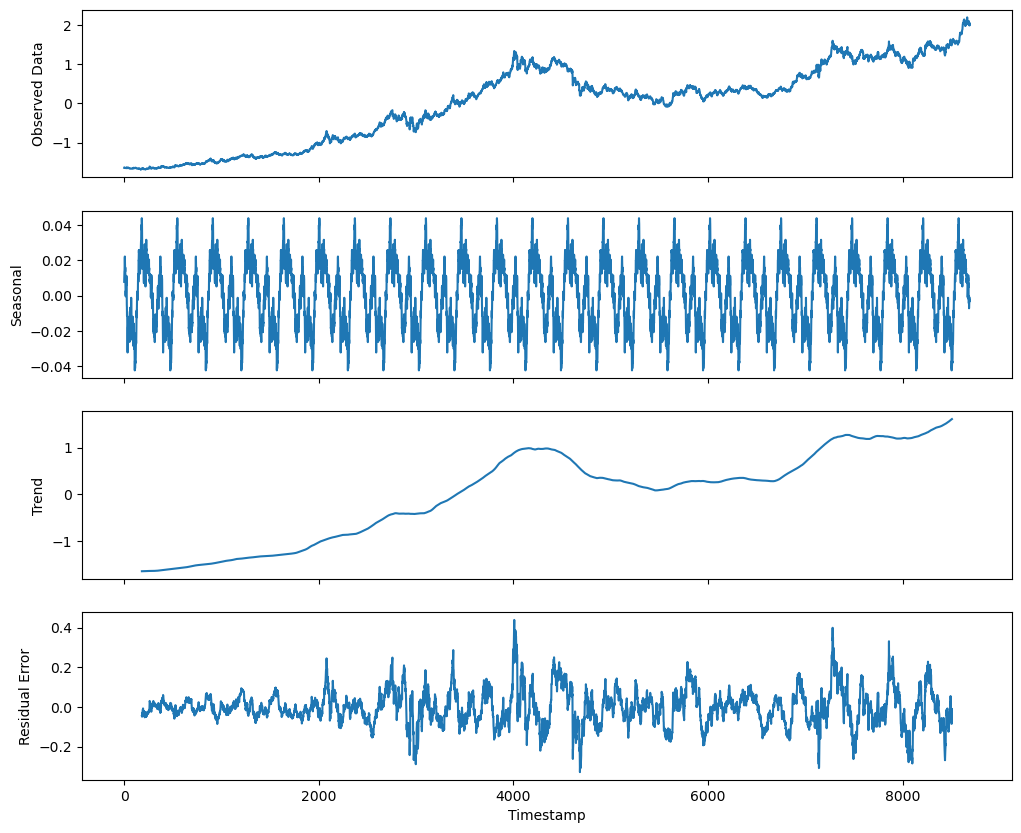

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Perform seasonal decomposition,using additive because had negative values
result = seasonal_decompose(df['Close_Normalised'], model='additive', period=365)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(12,10), sharex=True)
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed Data')
result.seasonal.plot(ax=ax2)
ax2.set_ylabel('Seasonal')
result.trend.plot(ax=ax3)
ax3.set_ylabel('Trend')
result.resid.plot(ax=ax4)
ax4.set_ylabel('Residual Error')
plt.xlabel("Timestamp")

In [18]:
# Split the data into training and testing sets
train_size = int(len(df['Close_Normalised']) * 0.8)
train_data = df['Close_Normalised'][:train_size]
test_data = df['Close_Normalised'][train_size:]
print("Train Size: ",train_size)

Train Size:  6952


### ETS building

In [19]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

start = time.time()
# Try Exponential smoothing (ETS model)
#The parameter used in ets model is error,trend,seasonal,damped trend,seasonal periods and initial levels.
#The error,trend and seasonal are set to be additive because the data is normalised and has negative values.
#The damped trend was set to False because the seasonal decomposition shows us the over trend is still increasing over time.
#Thus the long-term trend of the data is unstable.
#The seasonal period is set to 365 due to the seasonal plot indicating period = 365 is a strong seasonal pattern.
#The initial level is used to set the initial level of the time series model then the initial level is set to the mean of the data values.
ets_data = pd.Series(df['Close_Normalised']).astype('float64')
ets_model = ETSModel(ets_data, error='add', trend='add', seasonal = 'add', 
                     damped_trend=False, seasonal_periods=365, 
                     initial_level=ets_data.values.mean())
ets_fit = ets_model.fit()
end = time.time()

ets_fit.summary()

C:\Users\PC\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:       Close_Normalised   No. Observations:                 8690
Model:                       ETS(AAA)   Log Likelihood               23069.832
Date:                Thu, 04 Jul 2024   AIC                         -45397.665
Time:                        22:09:29   BIC                         -42774.721
Sample:                             0   HQIC                        -44503.581
                               - 8690   Scale                            0.000
Covariance Type:               approx                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
smoothing_level          0.9999      0.010     99.087      0.000       0.980       1.020
smoothing_trend       9.999e-05        nan        nan        nan         nan         nan
smoothing_seasonal    3.673e-06        nan        nan        nan         nan         nan
initial_level           -1.6386     46.426     -0.035      0.972     -92.632      89.355
initial_trend            0.0004      0.000      1.609      0.108   -9.28e-05       0.001
initial_seasonal.0    3.631e-05     46.426   7.82e-07      1.000     -90.993      90.993
initial_seasonal.1       0.0004     46.426   8.05e-06      1.000     -90.993      90.994
initial_seasonal.2      -0.0012     46.426  -2.61e-05      1.000     -90.994      90.992
initial_seasonal.3      -0.0037     46.426  -7.91e-05      1.000     -90.997      90.989
initial_seasonal.4    1.512e-05     46.426   3.26e-07      1.000     -90.993      90.993
initial_seasonal.5       0.0055     46.426      0.000      1.000     -90.988      90.998
initial_seasonal.6       0.0091     46.426      0.000      1.000     -90.984      91.002
initial_seasonal.7       0.0040     46.426   8.62e-05      1.000     -90.989      90.997
initial_seasonal.8       0.0043     46.426   9.21e-05      1.000     -90.989      90.997
initial_seasonal.9       0.0015     46.426   3.16e-05      1.000     -90.992      90.994
initial_seasonal.10     -0.0018     46.426  -3.96e-05      1.000     -90.995      90.991
initial_seasonal.11      0.0004     46.426   9.25e-06      1.000     -90.993      90.994
initial_seasonal.12     -0.0053     46.426     -0.000      1.000     -90.999      90.988
initial_seasonal.13     -0.0020     46.426  -4.25e-05      1.000     -90.995      90.991
initial_seasonal.14      0.0090     46.426      0.000      1.000     -90.984      91.002
initial_seasonal.15      0.0060     46.426      0.000      1.000     -90.987      90.999
initial_seasonal.16      0.0054     46.426      0.000      1.000     -90.988      90.998
initial_seasonal.17      0.0078     46.426      0.000      1.000     -90.985      91.001
initial_seasonal.18      0.0112     46.426      0.000      1.000     -90.982      91.004
initial_seasonal.19      0.0088     46.426      0.000      1.000     -90.984      91.002
initial_seasonal.20      0.0091     46.426      0.000      1.000     -90.984      91.002
initial_seasonal.21      0.0038     46.426   8.15e-05      1.000     -90.989      90.997
initial_seasonal.22      0.0062     46.426      0.000      1.000     -90.987      90.999
initial_seasonal.23      0.0079     46.426      0.000      1.000     -90.985      91.001
initial_seasonal.24      0.0071     46.426      0.000      1.000     -90.986      91.000
initial_seasonal.25      0.0067     46.426      0.000      1.000     -90.986      91.000
initial_seasonal.26      0.0071     46.426      0.000      1.000     -90.986      91.000
initial_seasonal.27      0.0054     46.426      0.000      1.000     -90.988      90.999
initial_seasonal.28     -0.0014     4

In [20]:
e = (end - start)/3600 #seconds to hours
print(f"Time Elasped: {e} hours ")
#Using 0.45 hours to train

Time Elasped: 0.4603388534651862 hours 


In [29]:
# Make predictions on the test set
pred_ets = ets_fit.predict(start=len(train_data), end=len(close)-1)

### Evaluation(ETS)

In [30]:
# Evaluate the model
mse_ets = mean_squared_error(test_data, pred_ets)
mae_ets = mean_absolute_error(test_data, pred_ets)

print("ETS model performance metrics")
print("Mean Squared Error (MSE):", mse_ets)
print("Mean Absolute Error (MAE):", mae_ets)
#The MSE of ARIMA is 0.0005 and MAE is 0.015
#The both values are quite low indicate the model is perform well

ETS model performance metrics
Mean Squared Error (MSE): 0.0004945327966212105
Mean Absolute Error (MAE): 0.014527523199324334


### Denormalisation

In [31]:
# Denormalize the predicted values
pred_ets = np.array(pred_ets)
pred_ets_denormalized = scaler.inverse_transform(pred_ets.reshape(-1, 1)).flatten()

from scipy.special import inv_boxcox
ets_prediction = inv_boxcox(pred_ets_denormalized, best_lambda)
p = pd.read_csv("Prediction.csv")
p["ETS"] = ets_prediction
p.to_csv("Prediction.csv")

### Forecasting

In [32]:
#ETS Forecasting
forecast_steps = 30
ets_forecast = ets_fit.forecast(steps = forecast_steps)

ets_forecast_values = np.array(ets_forecast)
ets_forecasting = scaler.inverse_transform(ets_forecast_values.reshape(-1, 1)).flatten()
ori = inv_boxcox(ets_forecasting, best_lambda)
ets_forecasting = pd.DataFrame(ori, columns=['ETS'])

In [65]:
f = pd.read_csv("Forecasting.csv")
f["ETS"] = ets_forecasting
f.to_csv("Forecasting.csv")

# ARIMA with Seasonal and Exogenoues

# ARIMAX

In [33]:
# Load dataset into dataframe
df = pd.read_csv("latest.csv") #ensure csv file same location with notebook
df["Date"] = pd.to_datetime(df["Date"]) #convert 'Date' column into Date data type
df.head()#show first 5 rows of data

#The first 5 columns are useless thus need to drop
#In this dataset,it include information of gold price such as [Open,High,Low,Close,Adj Close,Volume]
#It also included exogenoues data:
#IR: Interest Rate
#Brent Crude: Price of Crude Oil
#CPI: Consumer Price Index
#DXY: US Dollar Index

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,IR,Interest Rate,Brent Crude,CPI,DXY
0,0,2000-08-30,273.899994,273.899994,273.899994,273.899994,273.899994,0.0,5.4,3.045613,31.629130,57.9,104.400
1,1,2000-08-31,274.799988,278.299988,274.799988,278.299988,278.299988,0.0,5.4,3.045613,31.629130,57.9,104.400
2,2,2000-09-01,277.000000,277.000000,277.000000,277.000000,277.000000,0.0,3.5,2.885996,33.360476,57.6,105.888
3,3,2000-09-02,276.699997,276.699997,276.699997,276.699997,276.699997,0.5,3.5,2.885996,33.360476,57.6,105.888
4,4,2000-09-03,276.399994,276.399994,276.399994,276.399994,276.399994,1.0,3.5,2.885996,33.360476,57.6,105.888


### Data Preprocessing

In [34]:
df = df.drop(df.columns[0], axis=1)
#drop the useless coulum -- Unnamed:0

### Data Normalisation

In [37]:
transformed_data, best_lambda = stats.boxcox(df["Close"])
print("Best Lambda: ",best_lambda)

from sklearn.preprocessing import StandardScaler

# Extract column from DataFrame as array
close = transformed_data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(close.reshape(-1,1))
close = normalized_data.flatten()
df['Close_Normalised'] = close

Best Lambda:  1.199719222661275


In [38]:
#Normalised Exogenoues Data
#IR was set to be exogenoues data for closing price because the p-value of it in arimax and sarimax was<0.05
#It means that it contributed well in training model
ir = df['Interest Rate'].values
scaler_ir = StandardScaler()
normalized_ir = scaler_ir.fit_transform(ir.reshape(-1,1))
ir= normalized_ir.flatten()
df['IR_Normalised'] = ir

### Augmented Dicky-Fuller test

In [39]:
def stat(da):
    # Perform the stationarity check using the augmented Dicky-Fuller test
    result = adfuller(da)
    print("ADF Statistic: ", result[0])
    print("P-value: ", result[1])
    print("Critical values: ")
    #Key represent the significance level and value represents the corresponding critical value
    for key, value in result[4].items():
        print(f"{key}: {value}")

In [40]:
stat(df['Interest Rate'])
#ADF test:H0 = non-stationary,H1 = stationary
#ADF stat is more negative,p-value>0.05
#Thus fail to reject H0

ADF Statistic:  -3.0105226632872677
P-value:  0.03392333288109277
Critical values: 
1%: -3.43087999438482
5%: -2.861774230884607
10%: -2.5668946760890745


### Diferrencing

In [41]:
#Differencing to solve non-stationary
# Manually difference the data
data_diff = df['Close_Normalised'].diff().dropna()
df["Close_diff"] = data_diff

#Exogenous data also should be stationary data
data_diff = df['IR_Normalised'].diff().dropna()
df["IR_diff"] = data_diff

#Check if null value exist then fill with mean value
if df.isnull().values.any():
    print("Got Missing Values")
    df.fillna(df.mean(),inplace = True)
    
#"Got Missing Values" indicates that the nan values are exists

Got Missing Values


C:\Users\PC\AppData\Local\Temp\ipykernel_17520\1790959488.py:13: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df.fillna(df.mean(),inplace = True)


In [42]:
stat(df["IR_diff"])
#ADF stat = -111.08
#ADF stat < critical values,p-value<0.05
#Thus reject H0
#Time series data is stationary so we can start build time series model

ADF Statistic:  -111.0818667884481
P-value:  0.0
Critical values: 
1%: -3.43087999438482
5%: -2.861774230884607
10%: -2.5668946760890745


### ACF,PACF Finding

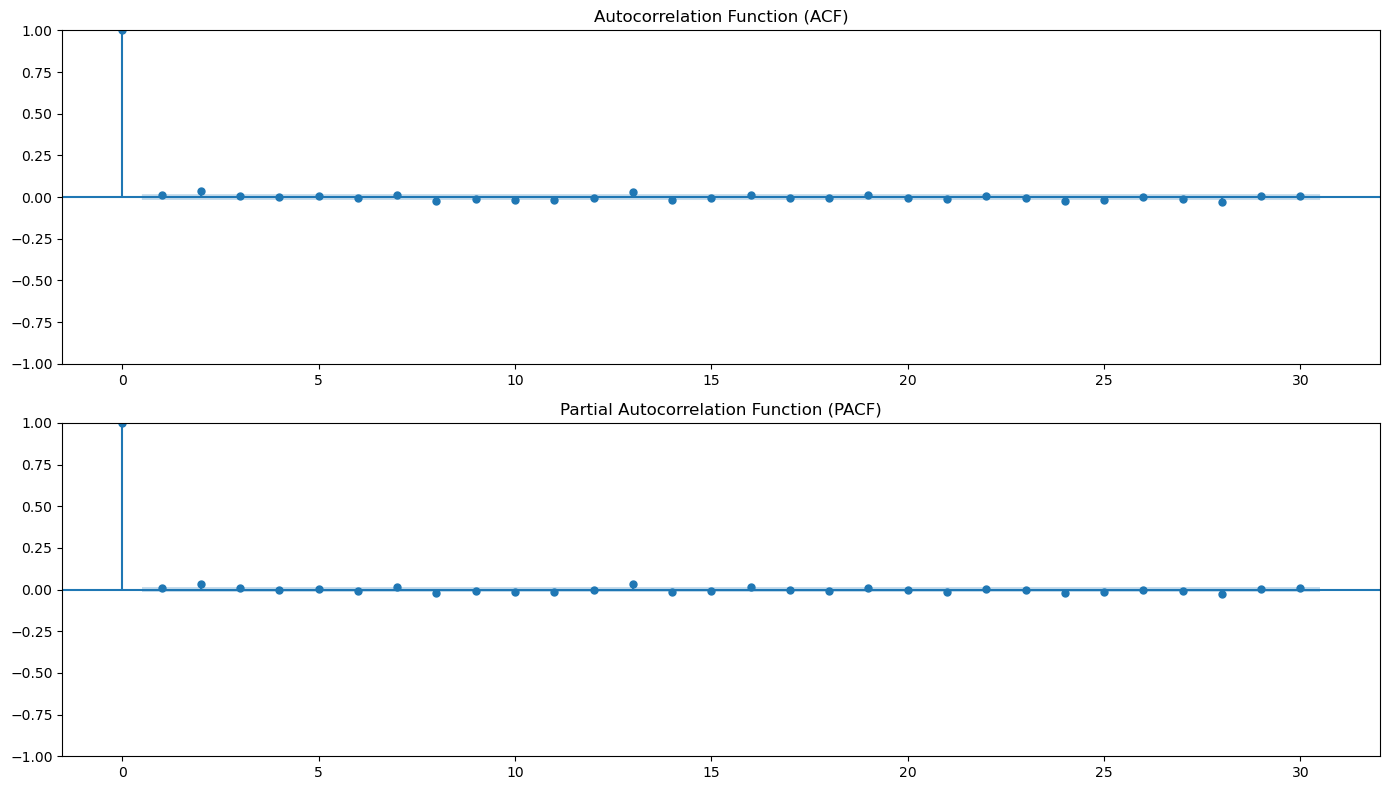

In [43]:
plt.figure(figsize=(14, 8))
# ACF plot
plt.subplot(2, 1, 1)
plot_acf(df["Close_diff"], lags=30, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
# PACF plot
plt.subplot(2, 1, 2)
plot_pacf(df["Close_diff"], lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()
#The ACF and PACF use range 30 of lag values to find the significant values
#After plotting the range of ACF and PACF is -0.25~ 1
#0 is the signifant value of ACF and PACF after observing to the graph. The lag values except 0 all are around
#There is hard to find the significant values of ACF and PACF so can perform some mathematics technique to solve the problem


In [44]:
# Get ACF and PACF values
acf_values = acf(df["Close_diff"], nlags=30)
pacf_values = pacf(df["Close_diff"], nlags=30)

# Calculate the 95% confidence interval threshold
n = len(df["Close_diff"])
threshold = 1.96 / np.sqrt(n)
# Count significant values for p and q
significant_p_values = sum(abs(pacf_values[1:]) > threshold)
significant_q_values = sum(abs(acf_values[1:]) > threshold)
# Print the results
print(f"Number of significant p values: {significant_p_values}")
print(f"Number of significant q values: {significant_q_values}")
p = significant_p_values
d = 1#d =1 because it had apply one time of differencing
q = significant_q_values
#After computing,the significant value is 5 and significant q value is 6

Number of significant p values: 5
Number of significant q values: 6


### Splitting Data

In [45]:
# Split the data into training and testing sets
train_size = int(len(df["Close_diff"]) * 0.8)
train_data = df["Close_diff"][:train_size]
test_data = df["Close_diff"][train_size:]

### ARIMAX Building

In [46]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the ARIMAX model with differenced data(target,exogenous)
#Arimax is Sarimax without seasonal order thus the all seasonal order are set to 0
model = SARIMAX(df["Close_diff"], exog = df["IR_diff"],order=(5, 1, 6),seasonal_order=(0, 0, 0, 0))

# Fit the model
arimax_fit = model.fit()

#show diagnostic of arimax model
arimax_fit.summary()

C:\Users\PC\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Close_diff   No. Observations:                12342
Model:               SARIMAX(5, 1, 6)   Log Likelihood               31301.347
Date:                Thu, 04 Jul 2024   AIC                         -62576.694
Time:                        22:16:50   BIC                         -62480.225
Sample:                             0   HQIC                        -62544.379
                              - 12342                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
IR_diff       -0.0075      0.003     -2.701      0.007      -0.013      -0.002
ar.L1         -1.8266      0.081    -22.438      0.000      -1.986      -1.667
ar.L2         -2.4508      0.171    -14.335      0.000      -2.786      -2.116
ar.L3         -2.2678      0.214    -10.608      0.000      -2.687      -1.849
ar.L4         -1.4972      0.164     -9.110      0.000      -1.819      -1.175
ar.L5         -0.7190      0.075     -9.555      0.000      -0.866      -0.572
ma.L1          0.8547      0.078     10.968      0.000       0.702       1.007
ma.L2          0.6487      0.103      6.308      0.000       0.447       0.850
ma.L3         -0.1646      0.079     -2.074      0.038      -0.320      -0.009
ma.L4         -0.7757      0.081     -9.593      0.000      -0.934      -0.617
ma.L5         -0.7966      0.101     -7.877      0.000      -0.995      -0.598
ma.L6         -0.7510      0.074    -10.195      0.000      -0.895      -0.607
sigma2         0.0004   1.48e-06    248.824      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   3.40   Jarque-Bera (JB):            243584.91
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               3.14   Skew:                            -0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Evaluation(ARIMAX)

In [47]:
# Make predictions on the test set
pred_arimax = arimax_fit.predict(start=len(train_data), end=len(df["Close_diff"])-1,exog = df["IR_diff"])

# Evaluate the model
mse_arimax = mean_squared_error(test_data, pred_arimax)
mae_arimax = mean_absolute_error(test_data, pred_arimax)

print("SARIMAX model performance metrics")
print("Mean Squared Error (MSE):", mse_arimax)
print("Mean Absolute Error (MAE):", mae_arimax)
#The MSE of ARIMA is 0.0008 and MAE is 0.016
#The both values are quite low indicate the model is perform well

SARIMAX model performance metrics
Mean Squared Error (MSE): 0.0008132599196381558
Mean Absolute Error (MAE): 0.01642597116075402


### Denormalisation

In [48]:
#Convert back the predicted values to same unit with actual values
last_train_value = df['Close_Normalised'].iloc[train_size - 1]

# Reconstruct the predict on the original scale
pred_arimax_original_scale = np.r_[last_train_value, pred_arimax].cumsum()
pred_arimax_original_scale = pred_arimax_original_scale[1:]

# Denormalize the predicted values
pred_arimax_denormalized = scaler.inverse_transform(pred_arimax_original_scale.reshape(-1, 1)).flatten()
from scipy.special import inv_boxcox
arimax_prediction = inv_boxcox(pred_arimax_denormalized, best_lambda)


### Forecasting

In [49]:
#ARIMAX Forecasting
forecast_steps = 30 #Forecast the nest 30days
arimax_forecast = arimax_fit.get_forecast(steps = forecast_steps, exog=df[['IR_diff']][-forecast_steps:])
#forecast with the exogenous data

arimax_forecast_values = arimax_forecast.predicted_mean#get forecast values

In [50]:
last_value = df['Close_Normalised'].iloc[-1]

# Reconstruct the forecast on the original scale
pred_forecast_original_scale = np.r_[last_value, arimax_forecast_values].cumsum()
pred_forecast_original_scale = pred_forecast_original_scale[1:]

# Denormalize the forecasted values
pred_forecast_denormalized = scaler.inverse_transform(pred_forecast_original_scale.reshape(-1, 1)).flatten()

from scipy.special import inv_boxcox
# y_transformed is your Box-Cox transformed data
# lambda_value is the lambda used during the Box-Cox transformation
arimax_forecasting = inv_boxcox(pred_forecast_denormalized, best_lambda)
arimax_forecasting = pd.DataFrame(arimax_forecasting, columns=['ARIMAX'])
#convert to data frame for plotting

In [51]:
f = pd.read_csv("Forecasting.csv")
f["ARIMAX"] = arimax_forecasting
f.to_csv("Forecasting.csv")

# SARIMAX 

### SARIMAX Building

In [52]:
# Seasonal Arimax
# Define the SARIMAX model with differenced data (target,exogenous)
#The p and q values were the signifant values which calculated before.
#The seasonal order(P,D,Q,s P and Q were also same to p and q
#The D was set to d because there doesn't apply seasonal differencing
#The period(s)was set to 7 for daily data weekly seasonality
#Although the period 365 had the strongest seasonal patterns but it doesn't be the period of this model
#Due to it required a stronger model training hardware
model = SARIMAX(df["Close_diff"], exog = df["IR_diff"],order=(5, 1, 6),seasonal_order=(5, 0, 6, 7))

# Fit the model
sarimax_fit = model.fit()

#diagnostic of Sarimax
sarimax_fit.summary()

C:\Users\PC\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        Close_diff   No. Observations:                12342
Model:             SARIMAX(5, 1, 6)x(5, 0, 6, 7)   Log Likelihood               31275.663
Date:                           Thu, 04 Jul 2024   AIC                         -62503.326
Time:                                   22:23:39   BIC                         -62325.229
Sample:                                        0   HQIC                        -62443.666
                                         - 12342                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
IR_diff       -0.0166      0.003     -6.003      0.000      -0.022      -0.011
ar.L1         -1.3396      0.057    -23.368      0.000      -1.452      -1.227
ar.L2         -1.5943      0.090    -17.685      0.000      -1.771      -1.418
ar.L3         -1.3792      0.113    -12.155      0.000      -1.602      -1.157
ar.L4         -0.9676      0.085    -11.318      0.000      -1.135      -0.800
ar.L5         -0.6356      0.050    -12.779      0.000      -0.733      -0.538
ma.L1          0.3747      0.055      6.841      0.000       0.267       0.482
ma.L2          0.2951      0.049      5.981      0.000       0.198       0.392
ma.L3         -0.1719      0.051     -3.385      0.001      -0.271      -0.072
ma.L4         -0.3965      0.054     -7.328      0.000      -0.503      -0.290
ma.L5         -0.3350      0.052     -6.491      0.000      -0.436      -0.234
ma.L6         -0.6851      0.047    -14.686      0.000      -0.777      -0.594
ar.S.L7        0.0134     14.536      0.001      0.999     -28.477      28.504
ar.S.L14       0.0077      2.213      0.003      0.997      -4.329       4.344
ar.S.L21      -0.0229      2.742     -0.008      0.993      -5.397       5.351
ar.S.L28      -0.0314      0.354     -0.089      0.929      -0.726       0.663
ar.S.L35       0.0046      0.989      0.005      0.996      -1.934       1.943
ma.S.L7       -0.0363     14.536     -0.002      0.998     -28.527      28.454
ma.S.L14      -0.0232      2.442     -0.010      0.992      -4.809       4.763
ma.S.L21       0.0066      2.546      0.003      0.998      -4.983       4.997
ma.S.L28      -0.0033      0.420     -0.008      0.994      -0.827       0.820
ma.S.L35      -0.0019      0.484     -0.004      0.997      -0.950       0.946
ma.S.L42       0.0074      0.070      0.106      0.916      -0.129       0.144
sigma2         0.0004   1.52e-06    242.657      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   4.57   Jarque-Bera (JB):            232965.86
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               3.10   Skew:                            -0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.34e+14. Standard errors may be unstable.
"""

### Evaluation(SARIMAX)

In [53]:
# Make predictions on the test set
pred_sarimax = sarimax_fit.predict(start=len(train_data), end=len(df["Close_diff"])-1,exog = df["IR_diff"])

# Evaluate the model
mse_sarimax = mean_squared_error(test_data, pred_sarimax)
mae_sarimax = mean_absolute_error(test_data, pred_sarimax)

print("SARIMAX model performance metrics")
print("Mean Squared Error (MSE):", mse_sarimax)
print("Mean Absolute Error (MAE):", mae_sarimax)
#The MSE of ARIMA is 0.0008 and MAE is 0.017
#The both values are quite low indicate the model is perform well
#The values also quite similar to results of ARIMAX

SARIMAX model performance metrics
Mean Squared Error (MSE): 0.0008134781271320499
Mean Absolute Error (MAE): 0.01651998900991436


### Denormalisation

In [54]:
last_train_value = df['Close_Normalised'].iloc[train_size - 1]

# Reconstruct the forecast on the original scale
pred_sarimax_original_scale = np.r_[last_train_value, pred_sarimax].cumsum()
pred_sarimax_original_scale = pred_sarimax_original_scale[1:]

# Denormalize the forecasted values
pred_sarimax_denormalized = scaler.inverse_transform(pred_sarimax_original_scale.reshape(-1, 1)).flatten()
from scipy.special import inv_boxcox
sarimax_prediction = inv_boxcox(pred_sarimax_denormalized, best_lambda)


### Forecasting

In [55]:
#SARIMAX Forecasting
forecast_steps = 30 #forecast the next 30 days
sarimax_forecast = sarimax_fit.get_forecast(steps = forecast_steps, exog=df[['IR_diff']][-forecast_steps:])

sarimax_forecast_values = sarimax_forecast.predicted_mean

In [56]:
#convert back to the original unit
last_value = df['Close_Normalised'].iloc[-1]

# Reconstruct the forecast on the original scale
pred_forecast_original_scale = np.r_[last_value, sarimax_forecast_values].cumsum()
pred_forecast_original_scale = pred_forecast_original_scale[1:]

# Denormalize the forecasted values
pred_forecast_denormalized = scaler.inverse_transform(pred_forecast_original_scale.reshape(-1, 1)).flatten()

from scipy.special import inv_boxcox
# y_transformed is your Box-Cox transformed data
# lambda_value is the lambda used during the Box-Cox transformation
sarimax_forecasting = inv_boxcox(pred_forecast_denormalized, best_lambda)
sarimax_forecasting = pd.DataFrame(sarimax_forecasting, columns=['SARIMAX'])

In [57]:
f = pd.read_csv("Forecasting.csv")
f["SARIMAX"] = sarimax_forecasting
f.to_csv("Forecasting.csv")

# Evaluation

### Metrics

In [58]:
# Create a DataFrame
results = pd.DataFrame({
    "Model": ["ARIMA", "ETS", "ARIMAX","SARIMAX"],
    "MSE": [0.0005, 0.0005, 0.0008,0.0008],
    "MAE": [0.0148, 0.0145, 0.0164,0.0165]
})

results.T

#All the results of each model were showed in this table
#The table show us the models perform well on predicting
#Thus can start forecasting using these models

,0,1,2,3
Model,ARIMA,ETS,ARIMAX,SARIMAX
MSE,0.0005,0.0005,0.0008,0.0008
MAE,0.0148,0.0145,0.0164,0.0165


### Results Plotting

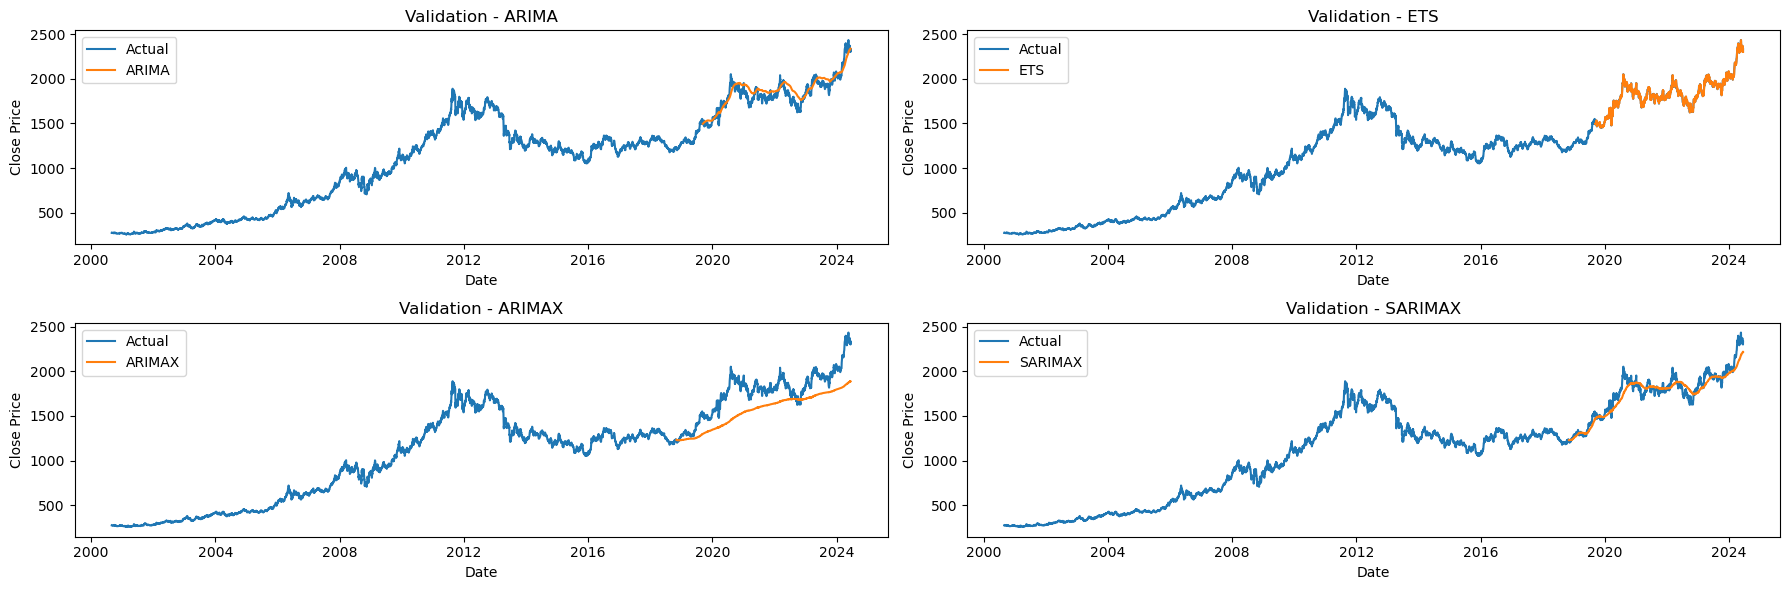

In [59]:
#Read the orevious data of arima and ets because they using different data
l = pd.read_csv("lat.csv")
l["Date"] = pd.to_datetime(l["Date"])  #set data to date format type
#Read the csv obtain predicted value of arima and ets
pre = pd.read_csv("Prediction.csv")
date_1 = l['Date']
date_2 = df['Date']

fig, axs = plt.subplots(2, 2, figsize=(18, 6)) #set the plotting format to 2rows and 2 columns

# Plot data for ARIMA
axs[0, 0].plot(date_1,l["Close"], label='Actual')
axs[0, 0].plot(date_1[6952:],pre["ARIMA"], label='ARIMA') #6952 is the train size of arima.[6952:] mean the index start from 6952 row
axs[0, 0].set_title('Validation - ARIMA')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Close Price')
axs[0, 0].legend()

# Plot data for ETS
axs[0, 1].plot(date_1, l["Close"], label='Actual')
axs[0, 1].plot(date_1[6952:], pre["ETS"], label='ETS')#6952 is the train size of ets.[6952:] mean the index start from 6952 row
axs[0, 1].set_title('Validation - ETS')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Close Price')
axs[0, 1].legend()

# Plot data for ARIMAX
axs[1, 0].plot(date_2, df["Close"], label='Actual')
axs[1, 0].plot(date_2[train_size:], arimax_prediction, label='ARIMAX')
axs[1, 0].set_title('Validation - ARIMAX')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Close Price')
axs[1, 0].legend()

# Plot data for SARIMAX
axs[1, 1].plot(date_2, df["Close"], label='Actual')
axs[1, 1].plot(date_2[train_size:], sarimax_prediction, label='SARIMAX')
axs[1, 1].set_title('Validation - SARIMAX')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Close Price')
axs[1, 1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Forecasting Results

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fore = pd.read_csv("Forecasting.csv")
fore["Date"] = pd.to_datetime(fore["Date"]) 

In [69]:
import yfinance as yf

gold = yf.download("GC=F", start="2024-06-14")


[*********************100%%**********************]  1 of 1 completed


### Results Plotting

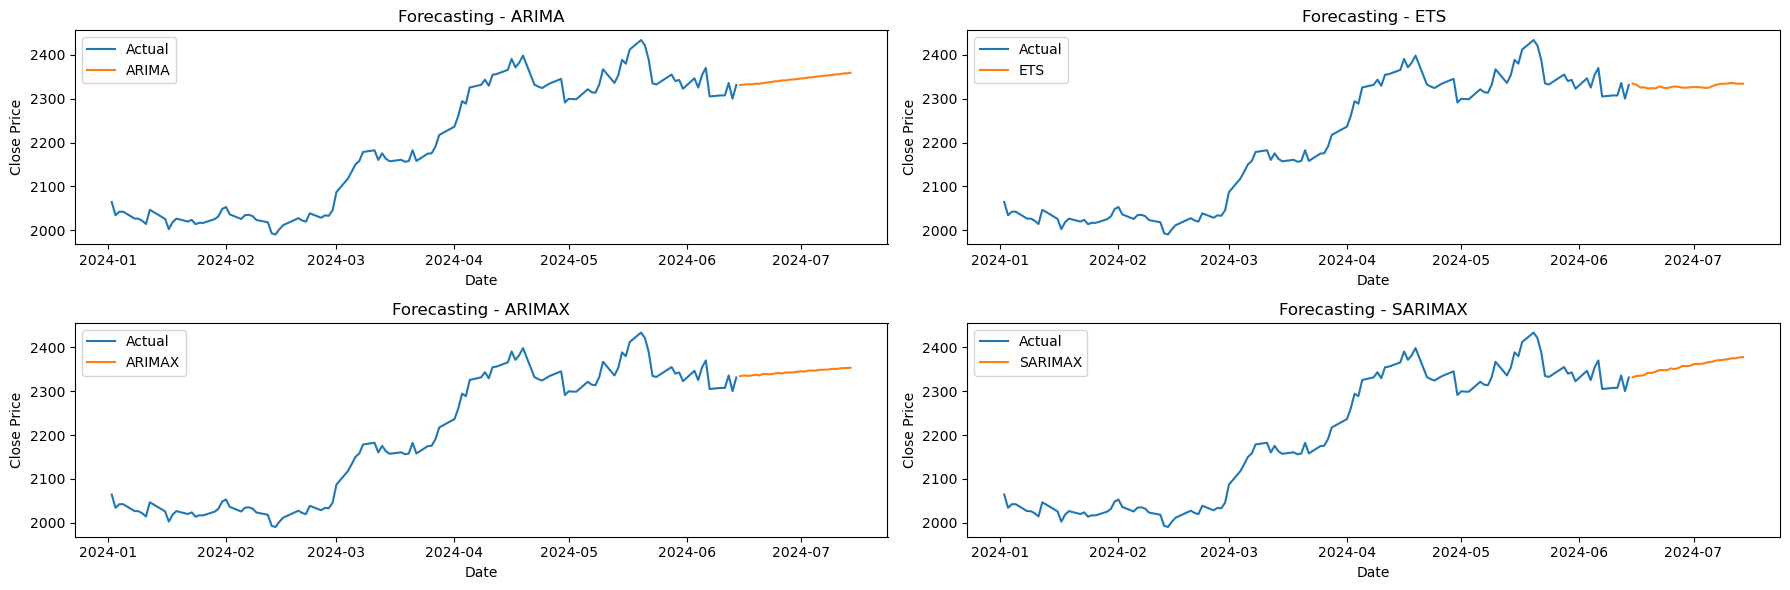

In [70]:
num_days = 165 #number of days(1st January 2024 - 14 June 2024)

date = fore["Date"]
df = pd.read_csv("latest.csv")
df["Date"] = pd.to_datetime(df["Date"]) 
date_1 = df["Date"] 
fig, axs = plt.subplots(2, 2, figsize=(18, 6))

# Plot data for model 1
axs[0, 0].plot(date_1[-165:],df[-165:]["Close"], label='Actual')
axs[0, 0].plot(date,fore["ARIMA"], label='ARIMA')
axs[0, 0].set_title('Forecasting - ARIMA')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Close Price')
axs[0, 0].legend()

# Plot data for model 2
axs[0, 1].plot(date_1[-165:], df[-165:]["Close"], label='Actual')
axs[0, 1].plot(date, fore["ETS"], label='ETS')
axs[0, 1].set_title('Forecasting - ETS')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Close Price')
axs[0, 1].legend()

# Plot data for model 3
axs[1, 0].plot(date_1[-165:], df[-165:]["Close"], label='Actual')
axs[1, 0].plot(date, fore["ARIMAX"], label='ARIMAX')
axs[1, 0].set_title('Forecasting - ARIMAX')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Close Price')
axs[1, 0].legend()

# Plot data for model 4
axs[1, 1].plot(date_1[-165:], df[-165:]["Close"], label='Actual')
axs[1, 1].plot(date, fore["SARIMAX"], label='SARIMAX')
axs[1, 1].set_title('Forecasting - SARIMAX')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Close Price')
axs[1, 1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

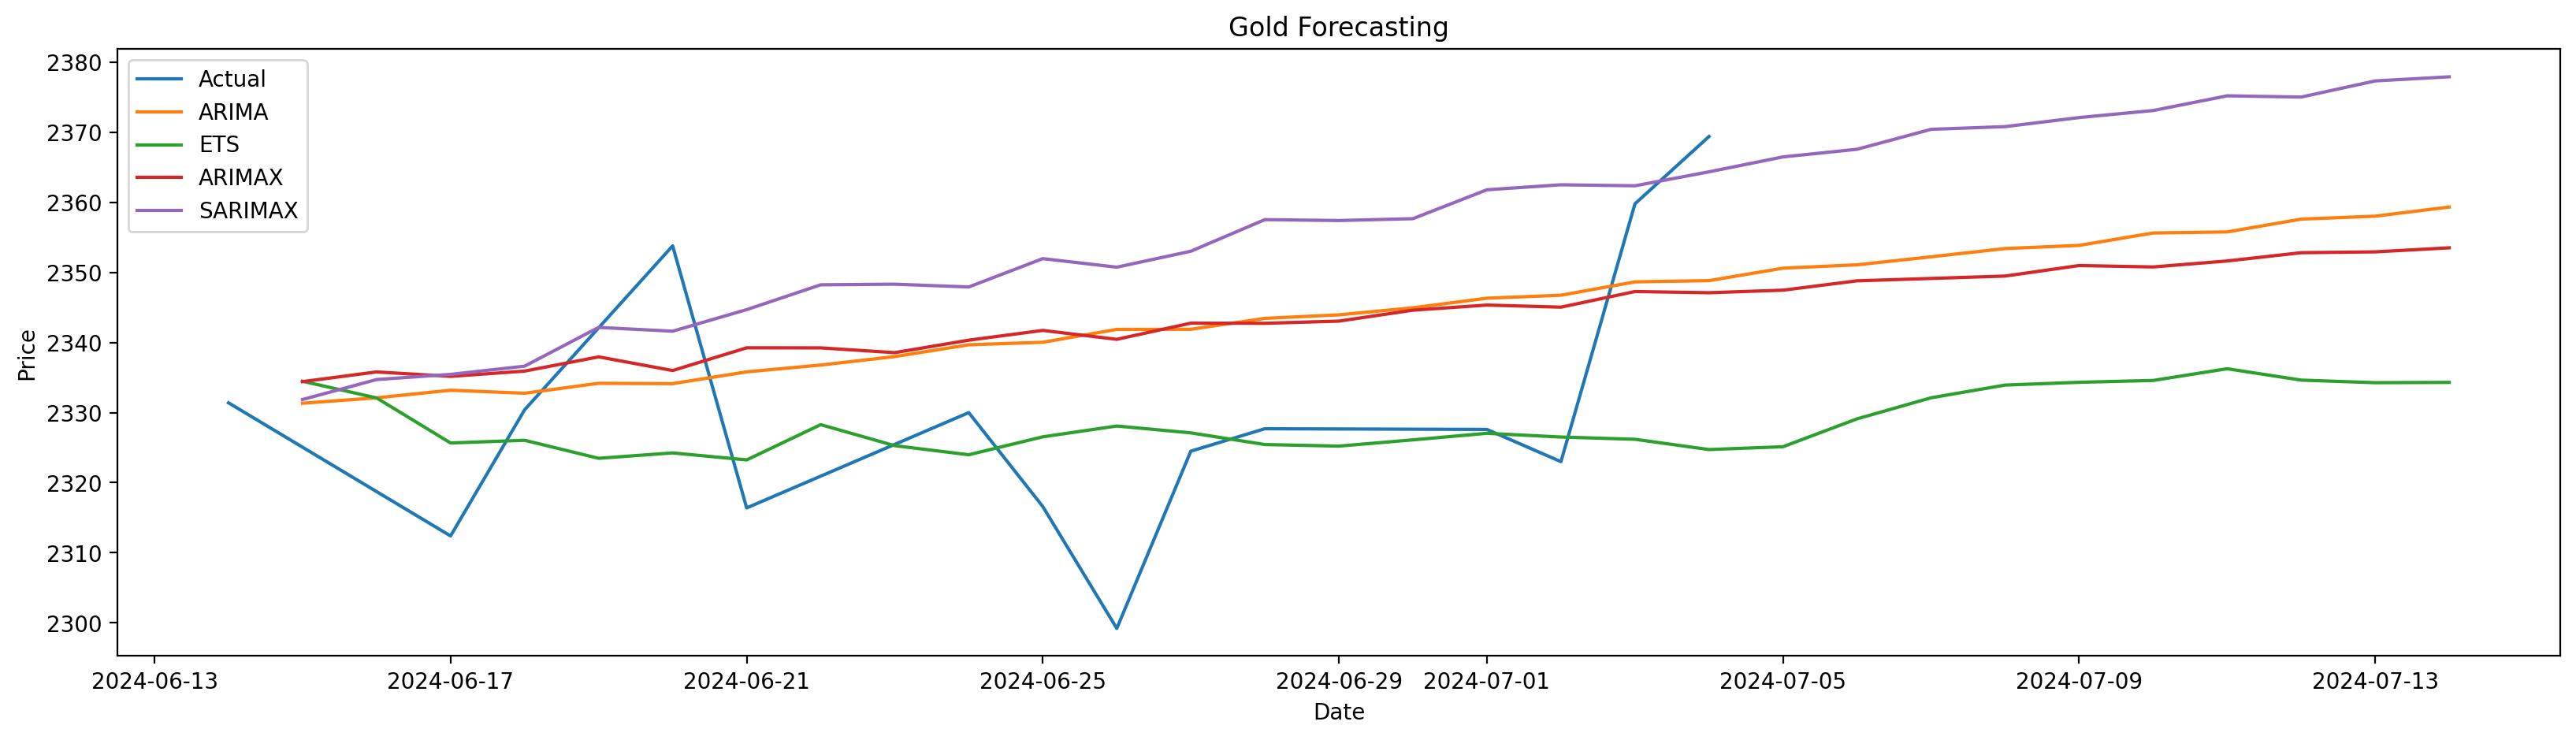

In [71]:
date = fore["Date"]

# Plot the actual values and predictions
plt.figure(figsize=(20,5), dpi=200)
plt.plot(gold["Close"], label="Actual")
plt.plot(date,fore["ARIMA"], label="ARIMA")
plt.plot(date,fore["ETS"], label="ETS")
plt.plot(date,fore["ARIMAX"], label="ARIMAX")
plt.plot(date,fore["SARIMAX"], label="SARIMAX")
#plt.plot(pred_arima, label="Predicted")
plt.title("Gold Forecasting")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [72]:
fore = fore.drop(fore.columns[0], axis=1)
fore = fore.loc[:, ~fore.columns.str.contains('^Unnamed')]

gold = gold["Close"].values
v = list(gold) + [np.nan] * (30 - len(gold))
v = pd.DataFrame(v, columns=['Actual'])
fore["Actual"] = v

### Comparison (forecast vs actual)

In [73]:
fore.head(10)

,Date,ARIMA,ARIMAX,SARIMAX,ETS,Actual
0,2024-06-15,2331.338586,2334.421283,2331.870011,2334.474843,2331.399902
1,2024-06-16,2332.110374,2335.807212,2334.717294,2332.099171,2312.399902
2,2024-06-17,2333.195248,2335.171372,2335.457612,2325.667565,2330.399902
3,2024-06-18,2332.764276,2335.923664,2336.628002,2326.050229,2353.800049
4,2024-06-19,2334.183416,2337.956455,2342.160377,2323.481787,2316.399902
5,2024-06-20,2334.133857,2336.006026,2341.619290,2324.249775,2330.000000
6,2024-06-21,2335.818416,2339.246918,2344.697931,2323.250891,2316.600098
7,2024-06-22,2336.788148,2339.238702,2348.240795,2328.282269,2299.199951
8,2024-06-23,2337.995252,2338.560016,2348.328283,2325.283553,2324.500000
9,2024-06-24,2339.680004,2340.339023,2347.930518,2323.986742,2327.699951


# Conclusion